# INFOMCDMMC Critical Data Mining of Media Culture

## Utrecht University, MSc Applied Data Science


### Team members:
* Meagan Loerakker, m.b.loerakker@students.uu.nl
* Celesta Terwisscha van Scheltinga, c.c.m.terwisschavanscheltinga@students.uu.nl
* Nina Alblas, n.m.alblas@students.uu.nl
* Berber van Drunen, b.p.vandrunen@students.uu.nl
* Debarupa Roy Choudhury, d.roychoudhury@students.uu.nl

# Combining Topic & Sentiment Analysis

## Import relevant libraries

In [23]:
# Stats
import pandas as pd

# Support
import re
import csv
import string

# Visualisation
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ninaalblas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ninaalblas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ninaalblas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [24]:
# Read the dataset with the processed data and the textblob description sentiment analysis results
df_sentiments = pd.read_csv("data/vader_textblob_sentiments.csv").iloc[:, 1:] 

# Remove unused sentiment analysis results
df_sentiments.drop(columns=["vader_body_sentiment", 
                            "vader_desc_sentiment", 
                            "textblob_body_sentiment_no_cutoff", 
                            "textblob_body_sentiment", 
                            "textblob_desc_sentiment_no_cutoff"], 
                   inplace=True)

# Remove duplicates
df_sentiments = df_sentiments[~df_sentiments.body.duplicated()]
df_sentiments = df_sentiments[~df_sentiments.description.duplicated()] 


df_sentiments.head(3)

,filename,outlet,title,description,datetime,body,year,month,preprocessed_description,preprocessed_body,textblob_desc_sentiment
0,2010-06-gears-of-war-3-beast.html,Wired,Gears of War 3 Co-op Makes Beasts of Gamers,"LOS ANGELES — Back in 2008, Gears of War 2 int...",2010-06-17 16:22:00.000,"LOS ANGELES – Back in 2008, Gears of War 2 in...",2010,6,los angeles gear war introduced horde mode co ...,los angeles gear war introduced horde mode co ...,1
1,sponsored-story-innovating-for-the-individual....,Wired,WIRED Brand Lab | Innovating for the Individual,What every leader can learn from the technolog...,2021-08-27 12:14:31.296,Innovative technology is making healthcare mor...,2021,8,leader learn transforming healthcare,innovative making healthcare personal bit inge...,0
2,ttps:--www.wired.com-story-for-all-mankind-bes...,Wired,‘For All Mankind’ Is the Best Sci-Fi of Its Era,The Apple TV+ alternate history series is simp...,2022-06-09 07:00:00.000,"New Star Wars, new Star Trek, Russian Doll, Se...",2022,6,apple tv alternate history series ambitious th...,new star war new star trek russian doll severa...,1


In [25]:
# Read the datasets which contain the topics for each outlet
def load_outlet_df(filename):
    """
    This function takes a filename and returns a selection of columns,
    namely columns from 'kmeans_clusters' up till 'topic_labels'

    Parameters:
    filename : type string
    """
    
    # read csv
    outlet_df = pd.read_csv(f"data/{filename}", index_col=0)
    
    # rename column
    outlet_df = outlet_df.rename(columns={"kmeans_clusters":"topic_labels"})
    
    # remove rows with duplicate bodies or descriptions
    outlet_df = outlet_df[~outlet_df.body.duplicated()]
    outlet_df = outlet_df[~outlet_df.description.duplicated()]
    
    return outlet_df

In [26]:
# Get a separate dataframe for each outlet -> these csv's contain the topics
df_gizmodo = load_outlet_df("df_gizmodo.csv")
df_guardian = load_outlet_df("df_guardian.csv")
df_nyt = load_outlet_df("df_nyt.csv")
df_wired = load_outlet_df("df_wired.csv")
df_wp = load_outlet_df("df_wp.csv")

df_wp.head(3)

,filename,outlet,title,description,datetime,body,category,text_nlp,features,topic_labels
Unnamed: 0,,,,,,,,,,
13568,news-the-switch-wp-2018-02-19-google-used-arti...,WashingtonPost,"In our eyes, Google’s software sees heart atta...",The new approach could one day allow people to...,2018-02-19 16:00:03.000,"By looking at the human eye, Google’s algorith...",NaN,"By looking at the human eye, Google’s algorith...",looking human eye google algorithm able predic...,1
13569,opinions-silicon-valley-should-work-with-the-m...,WashingtonPost,Silicon Valley should work with the military o...,If the best minds refuse to contribute to the ...,2018-09-12 23:16:27.000,GOOGLE DECIDED after an employee backlash this...,NaN,GOOGLE DECIDED after an employee backlash this...,google decided employee backlash summer wanted...,5
13570,news-the-switch-wp-2015-01-28-bill-gates-on-da...,WashingtonPost,Bill Gates on dangers of artificial intelligen...,Joining the likes of Stephen Hawking and Elon ...,2015-01-29 18:13:55.000,Bill Gates is a passionate technology advocate...,NaN,Bill Gates is a passionate technology advocate...,bill gate passionate technology advocate big s...,4


In [27]:
# Assign labels to each topic number (OVERARCHNG THEMES RATHER THAN SPECIFIC TOPICS)
# See report for more details on what topics fall under what overarching theme

# Generate labels for Gizmodo
resultGizmodo = []
for value in df_gizmodo["topic_labels"]:
    if value == 0:
        resultGizmodo.append("Entertainment & Culture")
    elif value == 1:
        resultGizmodo.append("Home")
    elif value == 2 or value == 7:
        resultGizmodo.append("Technology")
    elif value == 3:
        resultGizmodo.append("Games")
    elif value == 4:
        resultGizmodo.append("Social media")
    elif value == 5:
        resultGizmodo.append("Politics, Law & Finance")
    elif value == 6:
        resultGizmodo.append("Robots & Cars")
    else:
        resultGizmodo.append("Fail")

df_gizmodo["topics"] = resultGizmodo 

# Generate labels for the Guardian
resultGuardian = []
for value in df_guardian["topic_labels"]:
    if value == 0 or value == 2 or value == 4:
        resultGuardian.append("Technology")
    elif value == 1:
        resultGuardian.append("Politics, Law & Finance")
    elif value == 3 or value == 5 or value == 6:
        resultGuardian.append("Robots & Cars")
    elif value == 7:
        resultGuardian.append("Science & Research")
    elif value == 8:
        resultGuardian.append("Games")
    else:
        resultGuardian.append("Fail")
        
df_guardian["topics"] = resultGuardian  

# Generate labels for the New York Times
resultNYT = []
for value in df_nyt["topic_labels"]:
    if value == 0 or value == 6 or value == 7:
        resultNYT.append("Technology")
    elif value == 1:
        resultNYT.append("Science & Research")
    elif value == 2 or value == 3 or value == 11:
        resultNYT.append("Politics, Law & Finance")
    elif value == 4 or value == 9 or value == 10:
        resultNYT.append("Entertainment & Culture")
    elif value == 5:
        resultNYT.append("Cars & Robots")
    elif value == 8:
        resultNYT.append("Home")
    elif value == 12:
        resultNYT.append("Social media")
    else:
        resultNYT.append("Fail")
        
df_nyt["topics"] = resultNYT  

# Generate labels for Washington Post
resultWired = []
for value in df_wired["topic_labels"]:
    if value == 0 or value == 3 or value == 10:
        resultWired.append("Technology")
    elif value == 1 or value == 6:
        resultWired.append("Climate & Space")
    elif value == 2 or value == 7:
        resultWired.append("Social media")
    elif value == 4:
        resultWired.append("Robots & Cars")
    elif value == 5:
        resultWired.append("Entertainment & Culture")
    elif value == 8:
        resultWired.append("Politics, Law & Finance")
    elif value == 9:
        resultWired.append("Science & Research")
    elif value == 11:
        resultWired.append("Games")
    elif value == 12:
        resultWired.append("Security")
    else:
        resultWired.append("Fail")
        
df_wired["topics"] = resultWired  

# Generate labels for Washington Post
resultWP = []
for value in df_wp["topic_labels"]:
    if value == 0 or value == 8:
        resultWP.append("Politics, Law & Finance")
    elif value == 1:
        resultWP.append("Games")
    elif value == 2 or value == 7:
        resultWP.append("Robots & Cars")
    elif value == 3 or value == 12:
        resultWP.append("Social media")
    elif value == 4 or value == 6:
        resultWP.append("Science & Research")
    elif value == 5:
        resultWP.append("Home")
    elif value == 9:
        resultWP.append("Technology")
    elif value == 10 or value == 11 or value == 13:
        resultWP.append("Entertainment & Culture")
    else:
        resultWP.append("Fail")
        
df_wp["topics"] = resultWP  

df_wp.head(3)

,filename,outlet,title,description,datetime,body,category,text_nlp,features,topic_labels,topics
Unnamed: 0,,,,,,,,,,,
13568,news-the-switch-wp-2018-02-19-google-used-arti...,WashingtonPost,"In our eyes, Google’s software sees heart atta...",The new approach could one day allow people to...,2018-02-19 16:00:03.000,"By looking at the human eye, Google’s algorith...",NaN,"By looking at the human eye, Google’s algorith...",looking human eye google algorithm able predic...,1,Games
13569,opinions-silicon-valley-should-work-with-the-m...,WashingtonPost,Silicon Valley should work with the military o...,If the best minds refuse to contribute to the ...,2018-09-12 23:16:27.000,GOOGLE DECIDED after an employee backlash this...,NaN,GOOGLE DECIDED after an employee backlash this...,google decided employee backlash summer wanted...,5,Home
13570,news-the-switch-wp-2015-01-28-bill-gates-on-da...,WashingtonPost,Bill Gates on dangers of artificial intelligen...,Joining the likes of Stephen Hawking and Elon ...,2015-01-29 18:13:55.000,Bill Gates is a passionate technology advocate...,NaN,Bill Gates is a passionate technology advocate...,bill gate passionate technology advocate big s...,4,Science & Research


## Define a function to be able to plot the sentiments for each outlet's topic

In [28]:
def plot_sentiments_and_topics(outlet_df, sentiment_df, outlet, log_scale=False):
    """
    This function plots for each outlet its given topics, and
    per topic is given a distribution of the sentiment scores.
    This way, we can analyse the overall sentiment per outlet's topic(s).
    
    Parameters:
    outlet_df : the dataframe of the outlet with its corresponding topics
    sentiment_df : the dataframe for the sentiments
    outlet : type string (this corresponds to the name of the outlet, e.g. "Gizmodo")
    log_scale : boolean which is by default set to False
    """

    # Combine the sentiments and topics into one dataframe
    combined_df = pd.merge(sentiment_df, outlet_df)[["description", "topics", "textblob_desc_sentiment"]]
            
    # plot the sentiments per topic for this outlet
    df_sentiments_per_topic = combined_df.groupby(["topics", "textblob_desc_sentiment"]).count().unstack()
    df_sentiments_per_topic.plot(kind="bar",
                                 logy=log_scale,
                                 colormap="winter",
                                 title=f"TextBlob description sentiments per topic for {outlet}\n(edited cut-off points)")
    
    plt.legend(["-1", "0", "1"], title="sentiment")
    plt.savefig(f"plots/sentiments_topics_{outlet}.png", bbox_inches="tight")
    
    # save as csv
    combined_df.to_csv(f"data/sentiments_topics_{outlet}.csv")

    

## Plot the sentiments for each outlet's topic

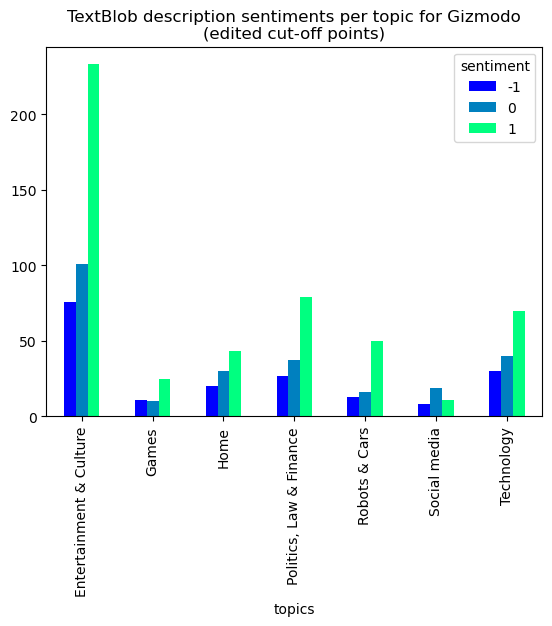

In [29]:
plot_sentiments_and_topics(df_gizmodo, df_sentiments, "Gizmodo")

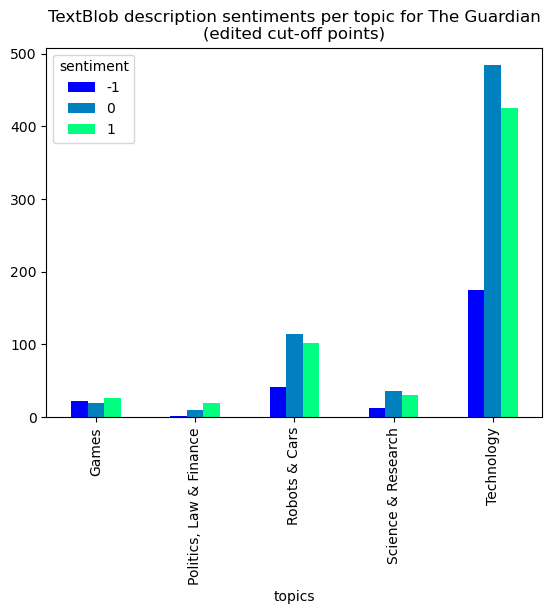

In [30]:
plot_sentiments_and_topics(df_guardian, df_sentiments, "The Guardian")

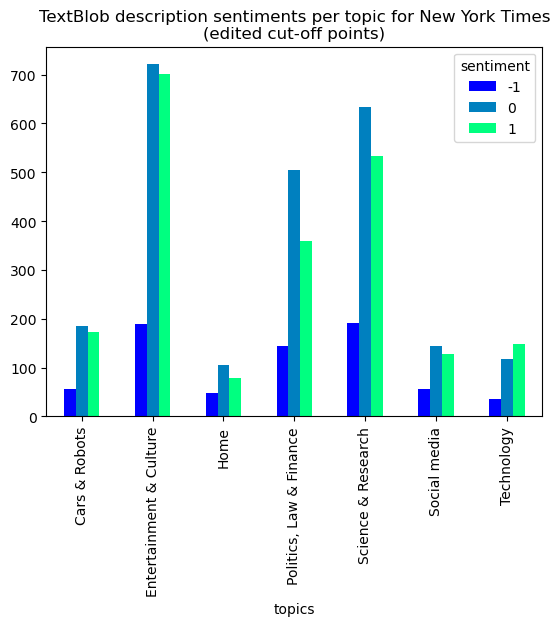

In [31]:
plot_sentiments_and_topics(df_nyt, df_sentiments, "New York Times") 

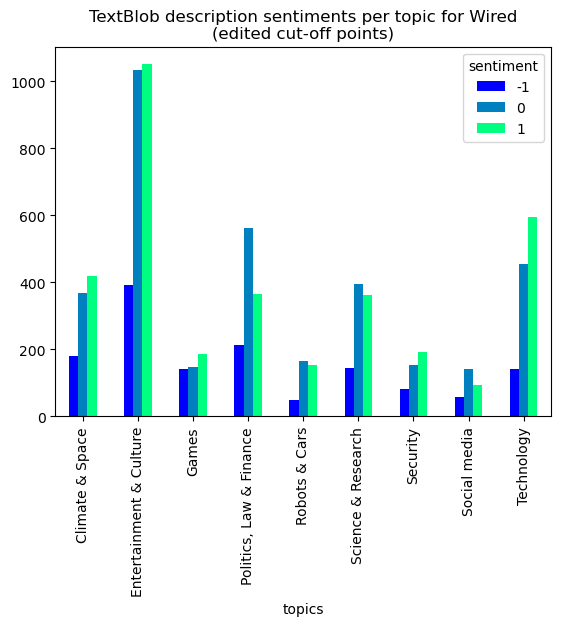

In [32]:
plot_sentiments_and_topics(df_wired, df_sentiments, "Wired")

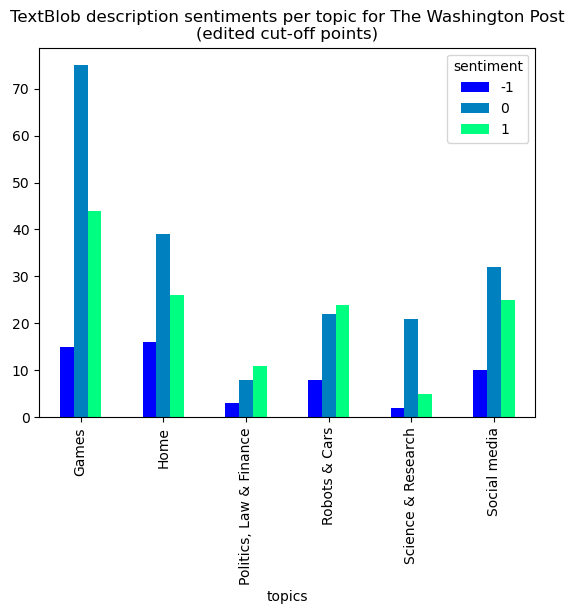

In [33]:
plot_sentiments_and_topics(df_wp, df_sentiments, "The Washington Post")